In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final

In [7]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda:0")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
V = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_true/V_diff_true_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)

In [8]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [9]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [10]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-10-fa9b8d4e78eb>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.7077697515487671
49 0.014983082190155983
99 0.003875045571476221
149 0.002525766147300601
199 0.0020913654007017612
249 0.0018780747195705771
299 0.0017447195714339614
349 0.0016545566031709313
399 0.0015900295693427324
449 0.0015417049871757627
499 0.001504069077782333
549 0.0014736601151525974
599 0.0014478572411462665
649 0.001422567991539836
699 0.0013965507969260216
749 0.0013789073564112186
799 0.0013638295931741595
849 0.0013501716312021017
899 0.0013377509312704206
949 0.0013263067230582237
999 0.0013162946561351418
1049 0.0013060587225481868
1099 0.0012964571360498667
1149 0.001287488266825676
1199 0.0012776016956195235
1249 0.0012674876488745213
1299 0.0012549374951049685
1349 0.0012426194734871387
1399 0.0012296306667849422
1449 0.001218497403897345
1499 0.0012082734610885382
1549 0.0012021841248497367
1599 0.0011949317995458841
1649 0.0011972831562161446
1699 0.0011895602801814675
1749 0.0011815786128863692
1799 0.0011738063767552376
1849 0.001227527973242104
1899 0.001

KeyboardInterrupt: 

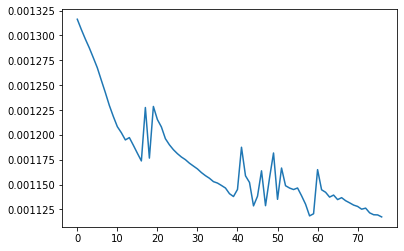

In [12]:
plt.plot(np.asarray(score_list)[20:97])

tensor(0.1179, device='cuda:0', grad_fn=<MaxBackward1>)


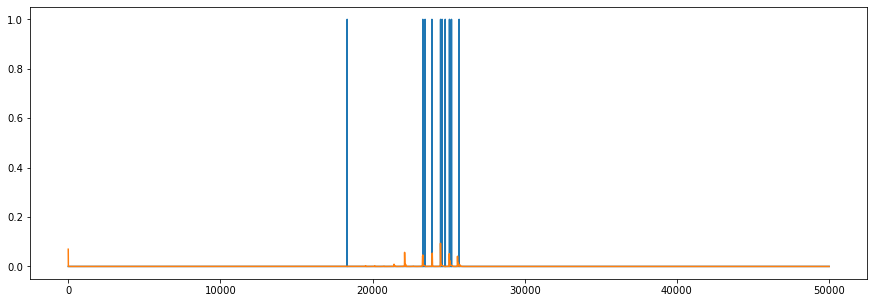

In [13]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [14]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms.pt")
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test.npy", test_S_out.cpu().detach().numpy())